# English-to-Spanish Translation Model
Thomas Cholak

need to install before we can download from kaggle

In [ ]:
pip install opendatasets

need for the transformer architecture

In [ ]:
pip install keras-transformer

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

In [ ]:
import opendatasets as od

# need username and key from kaggle api to download
od.download(
    "https://www.kaggle.com/datasets/lonnieqin/englishspanish-translation-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: thomascholak
Your Kaggle Key: ··········


100%|██████████| 2.72M/2.72M [00:00<00:00, 158MB/s]

First we download the dataset from Kaggle

In [ ]:
csv_file_path = "./englishspanish-translation-dataset/data.csv"

data = pd.read_csv(csv_file_path)
print("English to Spanish Dataset:\n\n", data.head())

English to Spanish Dataset:

   english  spanish
0     Go.      Ve.
1     Go.    Vete.
2     Go.    Vaya.
3     Go.  Váyase.
4     Hi.    Hola.


Then we effectively scramble the data:

In [ ]:
np.random.seed(56)  # random seed to ensure runs are same -> (can turn off)

# scrambles the data
shuffled_data = data.sample(frac=1).reset_index(drop=True)

# we add '[start]' and '[end]' tokens to the Spanish text
shuffled_data['spanish'] = "[start] " + shuffled_data['spanish'] + " [end]"

# then we add pair the sentences together
text_pairs = list(zip(shuffled_data['english'], shuffled_data['spanish']))

print("First five text-pairs:\n", (text_pairs[:5]))

First five text-pairs:
 [("We're investigating the murder of Tom Jackson.", '[start] Estamos investigando el asesinato de Tom Jackson. [end]'), ("Who knows what we'll find up in the attic?", '[start] ¿Quién sabe qué encontraremos en el ático? [end]'), ("I'm staying with Tom.", '[start] Me quedo con Tom. [end]'), ('I want to eat a mango.', '[start] Quiero comer un mango. [end]'), ("I'll show you around the town.", '[start] Te enseñaré la ciudad. [end]')]


Break into training, validation, and testing sets

In [ ]:
from sklearn.model_selection import train_test_split  # used to create our sets

In [ ]:
train_pairs, rest_pairs = train_test_split(text_pairs, test_size=35688, random_state=56)
validation_pairs, test_pairs = train_test_split(rest_pairs, test_size=17844, random_state=76)

print("Training pairs:", len(train_pairs))
print("Validation pairs:", len(validation_pairs)) # 'val' and 'test' same size
print("Test pairs:", len(test_pairs))

Training pairs: 83276
Validation pairs: 17844
Test pairs: 17844


Next we vectorize all of the data from the English and Spanish dataset pairs.

Adapted the below code block from ->
[Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition)
(Chapter 11).

In [ ]:
import re
import string
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [ ]:
# want to remove "¡" and "¿" characters
strip_chars = string.punctuation + "¿"
strip_chars = string.punctuation + "¡"

# preserves brackets while stripping all other punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000     # max allowed words in each language
sequence_length = 20   # max words allowed per sentence

def custom_standardization(string_tensor):
  lowercase_string = tf.strings.lower(string_tensor)
  return tf.strings.regex_replace(
    lowercase_string, f"[{re.escape(string.punctuation)}]", "")

# splits strings with the whitespace
def custom_split(string_tensor):
  return tf.strings.split(string_tensor)

english_vectorization = TextVectorization(  # source language
  output_mode="int",
  standardize=custom_standardization,
  output_sequence_length=sequence_length,
  split=custom_split,
  max_tokens=vocab_size,
)

spanish_vectorization = TextVectorization(  # target language
  output_mode="int",
  standardize=custom_standardization,
  output_sequence_length=sequence_length + 1,
  split=custom_split,
  max_tokens=vocab_size,
)

train_eng_texts = [pair[0] for pair in train_pairs]  # left  -> english
train_spa_texts = [pair[1] for pair in train_pairs]  # right -> spanish

english_vectorization.adapt(train_eng_texts)
spanish_vectorization.adapt(train_spa_texts)

Added some extra padding to the vectorized sequences in below block:

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras_transformer import get_model
import tensorflow as tf
import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

In [ ]:
def format_dataset(eng, spa):
    eng = english_vectorization(eng)
    spa = spanish_vectorization(spa)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": spa[:, :-1],
        },
        spa[:, 1:],
    )

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(64)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(validation_pairs)

for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


In [ ]:
for batch in train_ds.take(1):
    print(batch)

({'encoder_inputs': <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[  19,  333,   23, ...,    0,    0,    0],
       [  24,   96,    3, ...,    0,    0,    0],
       [   9,    8,    7, ...,    0,    0,    0],
       ...,
       [ 291,  672,    0, ...,    0,    0,    0],
       [  10, 5452,   20, ..., 1980,    0,    0],
       [   9,    8,  853, ...,    0,    0,    0]])>, 'decoder_inputs': <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[   2,   62,   11, ...,    0,    0,    0],
       [   2,   54, 1175, ...,    0,    0,    0],
       [   2,   20,   12, ...,    0,    0,    0],
       ...,
       [   2,   76,   61, ...,    0,    0,    0],
       [   2,   52, 8015, ...,   10, 1342,    4],
       [   2,   23,  667, ...,    0,    0,    0]])>}, <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[  62,   11,   22, ...,    0,    0,    0],
       [  54, 1175,   34, ...,    0,    0,    0],
       [  20,   12,   13, ...,    0,    0,    0],
       ...,
       [  76,   61,  859,

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Layer

Below functions integrated from the textbook:  https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/nlp/ipynb/neural_machine_translation_with_transformer.ipynb#scrollTo=noLdhrR_8WO4

In [ ]:
embed_dim = 256
latent_dim = 256
num_heads = 4

# uses positional embedding for later encoding
# followed functions from Chapter 11.3 of textbook (Chollet)
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            mask_zero=True
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length,
            output_dim=embed_dim,
            mask_zero=True
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

# encoder layer (uses positional embedding)
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.att = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# function to convert arrays back into legible words
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential([
            layers.Dense(latent_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask = None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask != None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask
        )

        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask
        )

        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        out = self.layernorm_3(out_2 + proj_output)

        return out

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

# create the actual network utilized for the model
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, num_heads, latent_dim)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

# connect both encoded and decoded inputs
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.45)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [ ]:
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 positional_embedding (Posi  (None, None, 256)            3845120   ['encoder_inputs[0][0]']      
 tionalEmbedding)                                                                                 
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                      

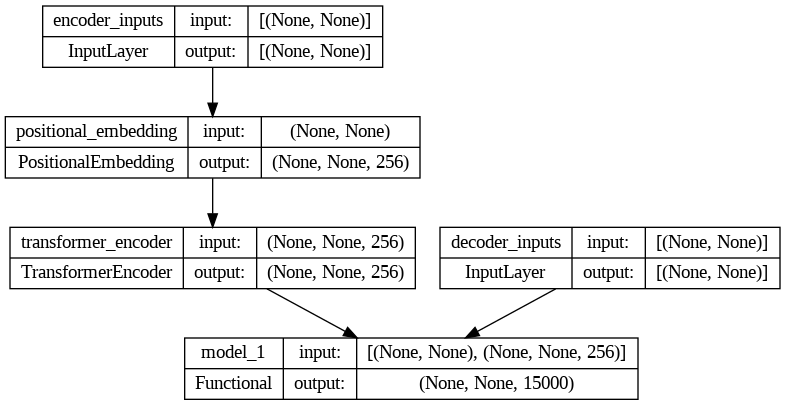

In [ ]:
from tensorflow import keras

keras.utils.plot_model(transformer, show_shapes=True)

In [ ]:
transformer.compile(
        "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

In [ ]:
# training the model
transformer.fit(train_ds, epochs=30, batch_size=64, validation_data=val_ds)

Epoch 1/30
1302/1302 [==============================] - 73s 56ms/step - loss: 2.7923 - accuracy: 0.5481 - val_loss: 2.0779 - val_accuracy: 0.6295
Epoch 2/30
1302/1302 [==============================] - 70s 54ms/step - loss: 2.0102 - accuracy: 0.6407 - val_loss: 1.7199 - val_accuracy: 0.6744
Epoch 3/30
1302/1302 [==============================] - 70s 54ms/step - loss: 1.6399 - accuracy: 0.6837 - val_loss: 1.5893 - val_accuracy: 0.6900
Epoch 4/30
1302/1302 [==============================] - 71s 54ms/step - loss: 1.4139 - accuracy: 0.7117 - val_loss: 1.5491 - val_accuracy: 0.6976
Epoch 5/30
1302/1302 [==============================] - 70s 53ms/step - loss: 1.2554 - accuracy: 0.7334 - val_loss: 1.4965 - val_accuracy: 0.7093
Epoch 6/30
1302/1302 [==============================] - 70s 54ms/step - loss: 1.1378 - accuracy: 0.7511 - val_loss: 1.4956 - val_accuracy: 0.7102
Epoch 7/30
1302/1302 [==============================] - 70s 53ms/step - loss: 1.0484 - accuracy: 0.7646 - val_loss: 1.4732 -

In [ ]:
transformer.save_weights("transformer_weights.h5")

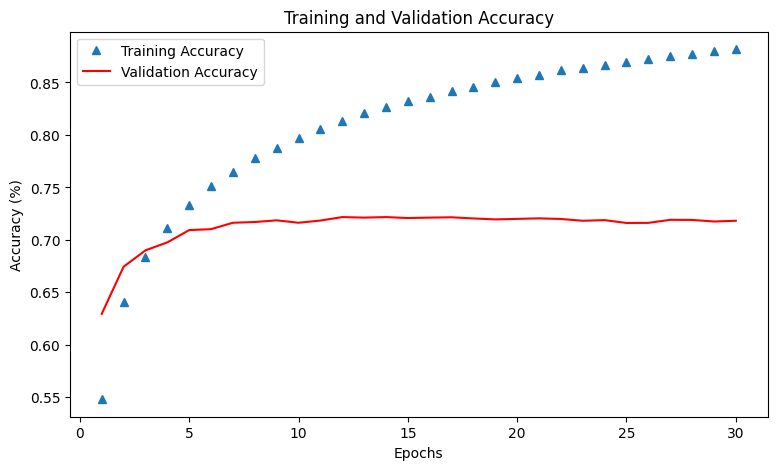

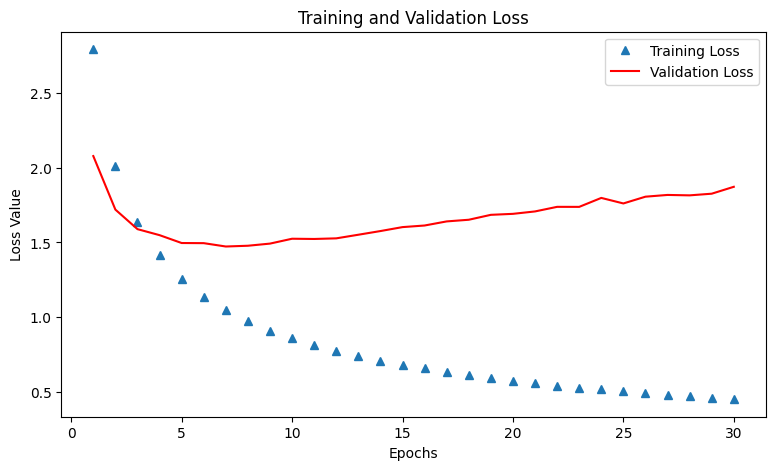

In [16]:
import matplotlib.pyplot as plt

# had to manually input data since I forgot to save my last run
train_accuracy = [0.5481, 0.6407, 0.6837, 0.7117, 0.7334, 0.7511, 0.7646, 0.7777, 0.7880, 0.7973,
                  0.8061, 0.8132, 0.8211, 0.8264, 0.8321, 0.8365, 0.8416, 0.8460, 0.8501, 0.8541,
                  0.8576, 0.8616, 0.8639, 0.8669, 0.8699, 0.8728, 0.8753, 0.8776, 0.8801, 0.8817]

val_accuracy = [0.6295, 0.6744, 0.6900, 0.6976, 0.7093, 0.7102, 0.7163, 0.7170, 0.7186, 0.7163,
                0.7184, 0.7217, 0.7212, 0.7217, 0.7208, 0.7212, 0.7215, 0.7204, 0.7195, 0.7200,
                0.7205, 0.7199, 0.7182, 0.7188, 0.7161, 0.7162, 0.7191, 0.7190, 0.7175, 0.7182]

# 30 epochs total
epochs = range(1, 31)

# plotting for accuracy
plt.figure(figsize=(9, 5))
plt.plot(epochs, train_accuracy, '^', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# tracks the loss
train_loss = [2.7923, 2.0102, 1.6399, 1.4139, 1.2554, 1.1378, 1.0484, 0.9722, 0.9115, 0.8610,
              0.8158, 0.7777, 0.7391, 0.7108, 0.6840, 0.6586, 0.6348, 0.6135, 0.5951, 0.5750,
              0.5613, 0.5433, 0.5304, 0.5178, 0.5039, 0.4923, 0.4822, 0.4706, 0.4596, 0.4521]

val_loss = [2.0779, 1.7199, 1.5893, 1.5491, 1.4965, 1.4956, 1.4732, 1.4783, 1.4926, 1.5252,
            1.5236, 1.5277, 1.5519, 1.5765, 1.6029, 1.6136, 1.6410, 1.6521, 1.6850, 1.6916,
            1.7077, 1.7384, 1.7382, 1.7981, 1.7611, 1.8063, 1.8180, 1.8152, 1.8263, 1.8724]

# plotting for loss
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, '^', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving transformer_weights.h5 to transformer_weights.h5


In [ ]:
transformer.load_weights("transformer_weights.h5")

Below function for decoding from textbook

In [ ]:
spanish_vocab = spanish_vectorization.get_vocabulary()
spanish_index_lookup = dict(zip(range(len(spanish_vocab)), spanish_vocab))

def remove_start_and_end_token(sentence):
    return sentence.replace("[start] ", "").replace(" [end]", "")

def decode_sequence(transformer, input_sentence):
    tokenized_input_sentence = english_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(sequence_length):
        tokenized_target_sentence = spanish_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spanish_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == " end":
            break
    return remove_start_and_end_token(decoded_sentence)

Then we can actually print the model's translations

In [ ]:
for i in np.random.choice(len(data), 10):
    item = data.iloc[i]
    translated = decode_sequence(transformer, item["english"])
    print("English:", remove_start_and_end_token(item["english"]))
    print("Spanish:", remove_start_and_end_token(item["spanish"]))
    cleaned_trans = translated.replace(" end", "").strip()
    rand_word = np.random.choice(spanish_vocab)
    cleaned_trans = cleaned_trans.replace(" [UNK]", " " + rand_word).strip()
    print("Translated:", cleaned_trans)

English: I try to save 10% of my wages each month.
Spanish: Cada mes intento ahorrar el 10% de mi sueldo.
Translated: intento ahorrar el 10 de mi sueldo
English: We found an anomaly.
Spanish: Encontramos una anomalía.
Translated: encontramos una apruebo
English: This song is catchy.
Spanish: Esta canción es pegadiza.
Translated: esta canción es hecha
English: Tom was watching Mary and John.
Spanish: Tom estaba observando a Mary y a John.
Translated: tom estaba observando a mary y a john
English: She quickly went up the stairs.
Spanish: Ella subió rápido por la escalera.
Translated: ella subió rápido por la escalera
English: I already told Tom everything I know.
Spanish: Ya le dije a Tom todo lo que sé.
Translated: ya le dije a tom todo lo que sé
English: Tom is the kind of guy that argues for fun.
Spanish: Tom es la clase de tipo que discute por diversión.
Translated: tom es el tipo de tipo de buen tipo funcionaban
English: They'll never know we're here.
Spanish: Ellos nunca sabrán que